## Task scope and goals

- **Develop an AI model that generate embeddings for shoes to provide better results in similiarity search**
- Deliverables 
    - Model written in any AI famework (TF, Pytorch, MXNet etc.)
    - Trained model parameters
    - Demo and/or explanation of model performance compared to existing model
- Model training may require
    - Additional images (which we can provide)
    - Labeling images apart from current category label
    - Training the model in the cloud infrastructure like AWS, GCP
- Evaluation criteria
    - Evaluation of the developed model will be a subjective evaluation against the current model

## Introduction
The rest of the document describes the similarity matching task for shoes we would like to develop/improve. It explores:
- images : how to download the images for this dataset
- embeddings : embeddings generated by our internal model for these images
- similariy search : generating similarity search index with embeddings for search
- issues/improvements - Examples of cases where we would like to see improvements


In [1]:
import numpy as np
import random
import faiss
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from PIL import Image
%matplotlib inline

Loading faiss with AVX2 support.


## 1. Images
The provided file `data_37887.tsv` contains the image formation. The file contains the following columns
- `img_id` : id of the image
- `cat_id` : category id of the image it's an internal list of ids (see below)
- `img_url` : image location
- `img_file` : local file name to save when downloading images (it's {img_root}/<img_id>.jpg)

In [39]:
df = pd.read_csv("/home/brillersys/Documents/data_37887.tsv", sep="\t")
df.head()

,img_id,cat_id,img_url,img_file
0,2476028888,2020101,https://img.b-static.com/images/1e6085deca69a5...,img/2476028888.jpg
1,2476176508,2020101,https://img.b-static.com/images/823c8fd20acf17...,img/2476176508.jpg
2,2499106658,2020101,https://img.b-static.com/images/e9eb35f016e5fe...,img/2499106658.jpg
3,2499096138,2020101,https://img.b-static.com/images/f6f44a12e9c3e4...,img/2499096138.jpg
4,2562722659,2020101,https://img.b-static.com/images/e08cd7c6f38301...,img/2562722659.jpg


The category IDs are indidcate following type of shoes.

| cat_id  	| Name (ladies)            	| cat_id  	| Name (mens)             	|
|---------	|--------------------------	|---------	|-------------------------	|
| 2020100 	| Ladies Shoes (top level) 	| 2020200 	| Men's Shoes (top level) 	|
| 2020101 	| Sandals                  	| 2020201 	| Sandals                 	|
| 2020102 	| Boots                    	| 2020202 	| Boots                   	|
| 2020103 	| Loafers                  	| 2020203 	| Loafers                 	|
| 2020104 	| Sneakers/Trainers        	| 2020204 	| Sneakers/Trainers       	|
| 2020105 	| Pumps                    	| 2020205 	| Business Shoes          	|
| 2020106 	| Mules                    	| 2020206 	| Casual Shoes            	|
| 2020107 	| Rain Shoes               	| 2020207 	| --                      	|


Notes:
1. Category IDs : `2020100` and `2020200` are meta categories for Ladies and Men's shoes
2. Categories  `2020101 ~ 7` and `2020201 ~ 7` are the actual categories assigned
2. Categories assginment is **not always correct** there are mis categorized items


The `img_url`s above can be used to download the images from our image servers. The below code download the images and save them to folder (`img_root`) in the format `<img_id>.jpg`. The rest of the code assumes that all the images are downloaded and available at `img_root` (ie. `img/`) folder.

**Note: This code is intentionally single threaded to avoid high load on our image servers.**

In [40]:
from tqdm.notebook import tqdm
import requests
import os

def fetch_url(entry):
    path, uri = entry
    if not os.path.exists(path):
        r = requests.get(uri, stream=True)
        if r.status_code == 200:
            with open(path, 'wb') as f:
                for chunk in r:
                    f.write(chunk)
    return path

# create img/ directory
img_root = 'img/'
if not os.path.exists(img_root):
    os.makedirs(img_root)
# download image files from URLs    
for img in tqdm(zip(df['img_file'], df['img_url']), total=len(df)):
    fetch_url(img)

In [41]:
!ls img/ | wc -l  # count the number of files == 37887

37887


## 2. Embeddings of images
This we provide the embeddings images from our current model. The embeedings (or features) of the each image are stored in two files.
- `footwear-features.npy` : a numpy array of features where `features[i]` contains the D-dimentional features of `i-th` image
- `footwear-idx.pkl` : a python pickled list `idx[i]` contains the image-id of `i-th` image

In [42]:
features_file = 'footwear-features.npy'
idx_file = 'footwear-idx.pkl'
# load features
features = np.load(features_file).astype('float32')
N, D = features.shape
# load image indexes
img_ids = pickle.load(open(idx_file, 'rb'))
# image file at each idx position (Note: images need to be downloaded from previous step)
img_files = [f'{img_root}/{img_id}.jpg' for img_id in img_ids ]

print(f"Feature set shape : {features.shape}")
print(f"Feature dimension : {D}")
print(f"# features/images : {N}")  # == len(img_ids)
assert(len(img_ids)==N)

Feature set shape : (37887, 512)
Feature dimension : 512
# features/images : 37887


Let's look at a sample image and it's embeddings. Note that only the first 5 values of the embedding vector is shown here for brevity.

image-id   : 2476019225
image-file : img//2476019225.jpg
embddings of the image : [ 0.06868536  0.00042199 -0.02236544 -0.06062778  0.00132688] .... 


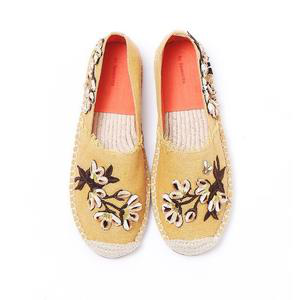

In [66]:
pos = np.random.randint(0, len(features))
print(f"image-id   : {img_ids[pos]}")
print(f"image-file : {img_files[pos]}")
print(f"embddings of the image : {features[pos][:5]} .... ") # Only first 5 values of the vector shown for brevity
Image.open(img_files[pos])

## 3. Similarity Search with embeddings
This part demonstrates the similarity search quality of current embeddings. We use faiss library to create index for similarity search. 
- A similarity search index is created using Faiss using given embeddings
- A random image is sampled and searched against the index
- Top 10 - similar images are visualized for analysis



In [44]:
# Create Faiss index for (cosine) similarity for search
quantizer = faiss.IndexFlatIP(D)
clusters = 16
index = faiss.IndexIVFFlat(quantizer, D, clusters, faiss.METRIC_INNER_PRODUCT)
# Train and add features to index
index.train(features)
index.add(features)
print(f"index trained {index.is_trained}, # of features in index {index.ntotal}")

index trained True, # of features in index 37887


Following is code is used to do the search on `index` and plot the closest matching products.

In [45]:
def plot_predictions(images):
    """plot predictions in image grid. First image is the search image.
    """
    gs = gridspec.GridSpec(3, 4)
    fig = plt.figure(figsize=(15, 15))
    gs.update(hspace=0.1, wspace=0.1)
    for i, (gg, image) in enumerate(zip(gs, images)):
        gg2 = gridspec.GridSpecFromSubplotSpec(10, 10, subplot_spec=gg)
        ax = fig.add_subplot(gg2[:,:])
        ax.imshow(image, cmap='Greys_r')
        ax.tick_params(axis='both',       
                       which='both',      
                       bottom='off',      
                       top='off',         
                       left='off',
                       right='off',
                       labelleft='off',
                       labelbottom='off') 
        ax.axes.set_title("result [{}]".format(i))
        if i == 0:
            plt.setp(ax.spines.values(), color='red')
            ax.axes.set_title("SEARCH")

def search(search_features, k):
    """ search images in similarity index and plot resulting images
    """
    distances, indices  = index.search(search_features, k)
    image_files = [img_files[idx] for idx in indices[0]]
    images = [plt.imread(file_) for file_ in image_files]
    plot_predictions(images)
    return image_files

CPU times: user 846 ms, sys: 31.9 ms, total: 878 ms
Wall time: 674 ms


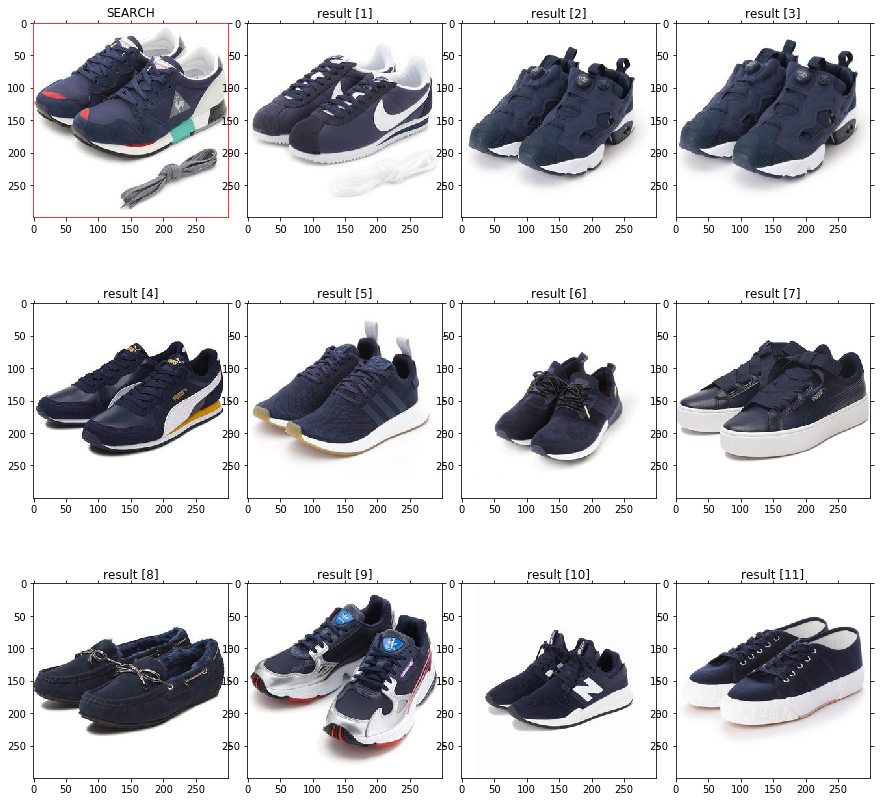

In [46]:
%%time
# find K- similar products
# since we sample features from the index itself, first hit is always the given product
k = 12
pos = np.random.randint(0, len(features))  # random image (pos) in feature set
image_files = search(np.expand_dims(features[pos], axis=0), k) # use features of this image for search

## 4. Cases for improvements to the model

### 4.1 Better matching results are  far in matching distance
In the case of below matching first two rows are have a better matching quality. However, result[10] 
should be more up in the ranking compared to result[8, 9] even results[4, 7]

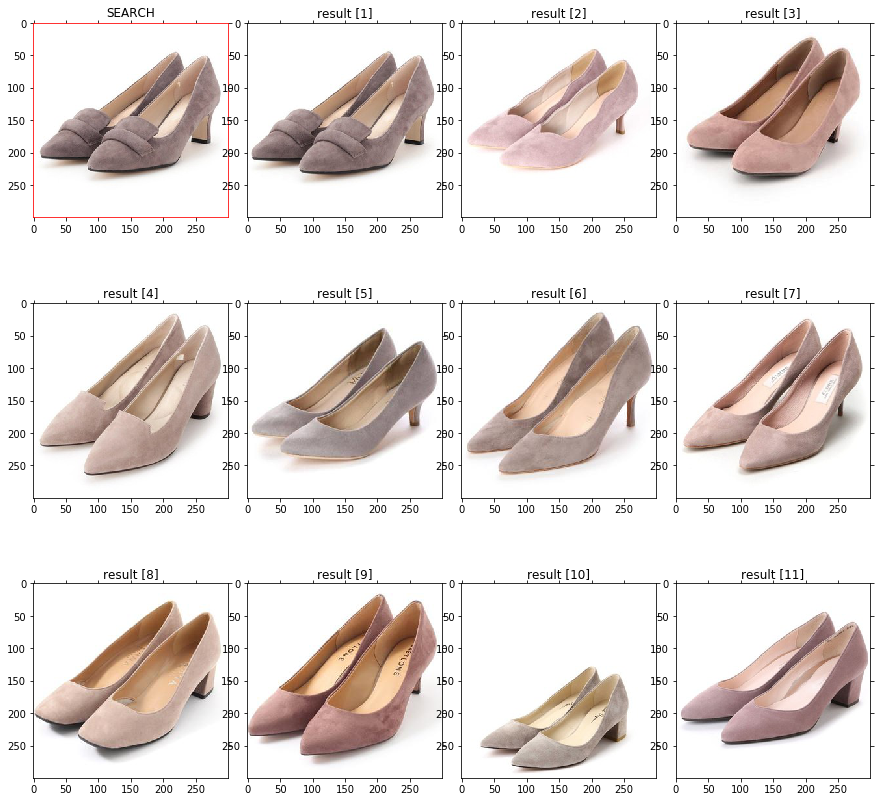

In [61]:
pos = 11567
image_files = search(np.expand_dims(features[pos], axis=0), k)

Below the pattern matching is quite good. However result[4,5,6] are better matching than result[3]. The model don't give focus to the shape of the shoe when the pattern is matching. 

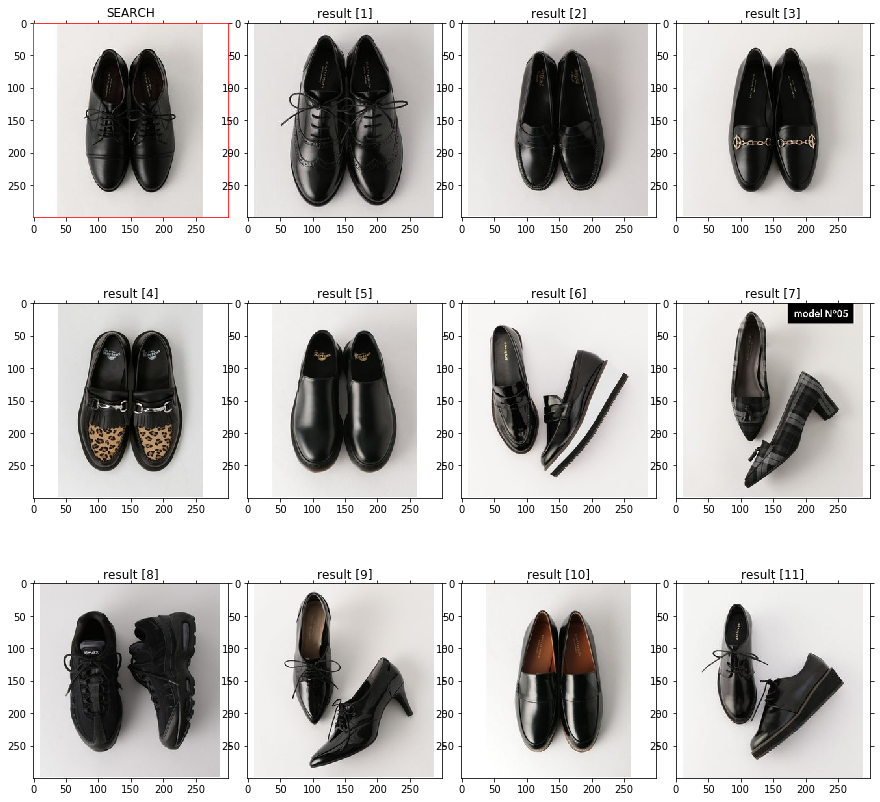

In [51]:
pos = 34519
image_files = search(np.expand_dims(features[pos], axis=0), k)

### 4.2 Shoe images in real life
When a search image is not a studio photo (ie. someone wearing it and sometimes with a background) the model
fails to find good matches. The result are more similar in background.

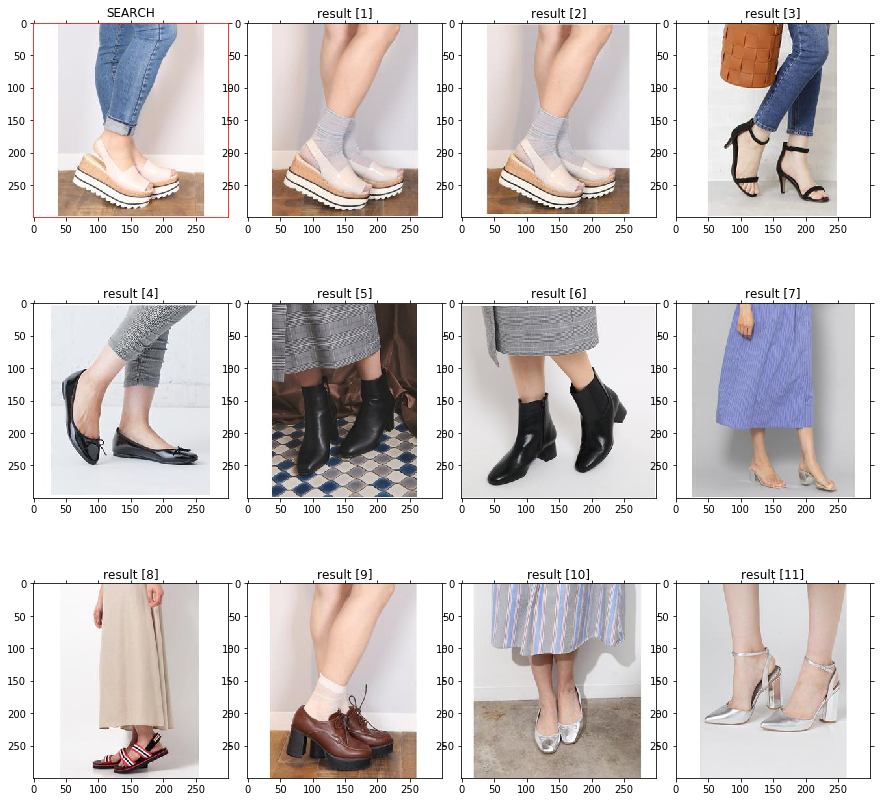

In [58]:
pos = random.choice([6061, 26002, 35256, 13534, 27275, 4829])
image_files = search(np.expand_dims(features[pos], axis=0), k)

### 4.3 Focus on color outweight the overall style
Model focus on color of the shoe rather than the style of the shoe. Here it goes for the white/gray/sliver colors
and result contain a range of styles. We would like to see model return similar style images even if the color doesn't match correctly.

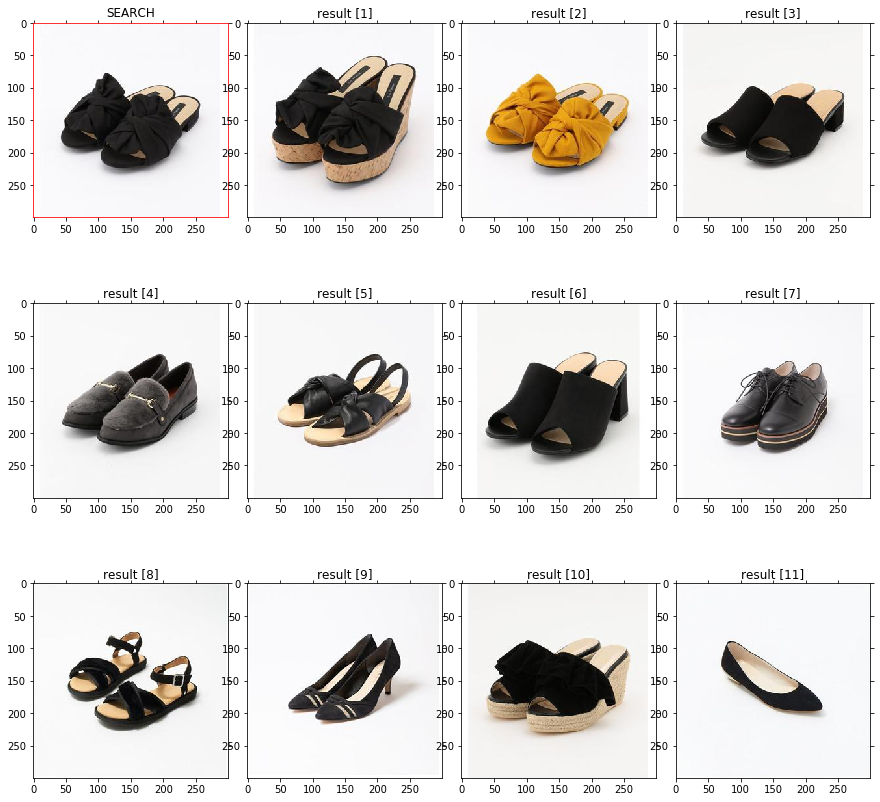

In [54]:
pos = 3459
image_files = search(np.expand_dims(features[pos], axis=0), k)